In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [28]:
# Load all MLB data and combine/merge them into one table

In [2]:
pitches = pd.read_csv("/Users/bradyhong/Downloads/archive/pitches.csv")

In [3]:
atbats = pd.read_csv('/Users/bradyhong/Downloads/archive/atbats.csv')

In [4]:
games = pd.read_csv('games.csv') 

In [5]:
names = pd.read_csv('/Users/bradyhong/Downloads/archive/player_names.csv')

In [6]:
# Merging pitches and atbats by ab_id
data = pd.merge(pitches, atbats, on = 'ab_id', how = 'left')

In [7]:
# Merging games data with pitches and atbats by g_id
data = pd.merge(data, games, on = 'g_id', how = 'left')

In [8]:
data1 = data.g_id.astype('str')

In [9]:
# Since the year is the first four characters, we will isolate those characters
data1 = data1.str[:4]

In [10]:
data['year'] = data1.values

In [11]:
data1718 = data[(data['year'] == '2017') | (data['year'] == '2018')]

In [12]:
data1718 = pd.merge(data1718, names, left_on = 'pitcher_id', right_on = 'id')

In [13]:
data1718.to_csv("data1718.csv")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-6f78cff7aefa>", line 1, in <module>
    data1718.to_csv("data1718.csv")
  File "/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 3204, in to_csv
    formatter.save()
  File "/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/csvs.py", line 204, in save
    self._save()
  File "/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/csvs.py", line 325, in _save
    self._save_chunk(start_i, end_i)
  File "/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/csvs.py", line 356, in _save_chunk
    libwriters.write_csv_rows(self.data, ix, self.nlevels, self.cols, self.writer)
  File "pandas/_libs/writers.pyx", line 48, in pandas._libs.writers.wr


KeyboardInterrupt



In [15]:
# start from below, if data17.csv is ready

In [ ]:
data1718 = pd.read_csv("data1718.csv")

In [ ]:
data1718_merge = pd.DataFrame(data1718[['pitch_type', 'pitcher_id', 'year']])

In [ ]:
# drop the outliers
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'AB']
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'UN']
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'EP']
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'SC']
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'PO']
data1718_merge = data1718_merge[data1718_merge.pitch_type != 'FO']

In [ ]:
data1718_merge.dropna(inplace=True) # now it will actually drop the nan values

In [ ]:
data1718_merge.pitch_type.value_counts()

In [ ]:
pitcherid=set()
for i in data1718_merge.pitcher_id:
    pitcherid.add(i)

In [ ]:
len(pitcherid)

Combining FF and FT to FB (Fastball); KN and KC to KN (Knuckleball)

In [ ]:
data1718_merge.pitch_type = data1718_merge.pitch_type.replace({"FF": "FB", "FT": "FB", "KC": "KN"})

In [ ]:
data1718_merge.pitch_type.value_counts()

modified version of proportion calculator (faster)

In [ ]:
new_1718 = pd.DataFrame()
new_1718['pitcher_id'] = [i for i in pitcherid]
new_1718

In [ ]:
# for indexing purpose, create a dictionary {pitcher_id: index}
pitcher_locator = dict()
for i, row in new_1718.iterrows():
    pitcher_locator[int(row['pitcher_id'])] = i

In [ ]:
# MODIFIED: 'FF' and 'FT' becomes 'FB'; 'KN' and 'KC' are combined into 'KN'
# Get the pitch type proportion for each pitcher, from 2017 data
index = data1718_merge.index
new_1718['FB'] = 0
new_1718['SL'] = 0
new_1718['CH'] = 0
new_1718['CU'] = 0
new_1718['SI'] = 0
new_1718['FC'] = 0
new_1718['FS'] = 0
new_1718['KN'] = 0

In [51]:
data1718_merge

,pitch_type,pitcher_id,year
0,FB,593372,2017
1,FB,593372,2017
2,FB,593372,2017
3,SL,593372,2017
4,FB,593372,2017
...,...,...,...
1449057,CU,607054,2018
1449058,CH,607054,2018
1449059,CU,607054,2018
1449060,CU,607054,2018


In [ ]:
'''
for 2017 data, 1 will be added; for 2018 data, 4 will be added
'''
ratio = {2017: 1, 2018: 4}
start = dt.datetime.now()
print("Start:", start)
for _, row in data1718_merge.iterrows():
    # print(row['pitcher_id'], row['pitch_type'])
    # print(pitcher_locator[row['pitcher_id']])
    #print(row['pitch_type'])
    # print("this", pitcher_locator[row['pitcher_id']], row['pitch_type'])
    new_1718.loc[pitcher_locator[row['pitcher_id']], str(row['pitch_type'])] += ratio[int(row['year'])]
print("End:", dt.datetime.now())
print()
print("It took...", dt.datetime.now() - start)

In [ ]:
proportion = new_1718.iloc[:, 1:].div(new_1718.iloc[:, 1:].sum(axis=1), axis=0)

In [ ]:
proportion['pitcher_id'] = [i for i in pitcherid]
cols = proportion.columns.tolist()
cols = cols[-1:] + cols[:-1]
proportion = proportion[cols]

In [56]:
proportion

,pitcher_id,FB,SL,CH,CU,SI,FC,FS,KN
0,466948,0.532710,0.009346,0.355140,0.102804,0.000000,0.000000,0.000000,0.000000
1,456713,0.660906,0.017281,0.001920,0.197389,0.000000,0.122504,0.000000,0.000000
2,622608,0.661909,0.197529,0.071480,0.069081,0.000000,0.000000,0.000000,0.000000
3,501789,0.081851,0.000000,0.000000,0.365362,0.000000,0.552788,0.000000,0.000000
4,596001,0.316554,0.326886,0.059427,0.077449,0.219685,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
991,489448,0.750000,0.175000,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000
992,475115,0.515793,0.408435,0.011868,0.000000,0.000000,0.063904,0.000000,0.000000
993,456696,0.569178,0.197318,0.031503,0.202001,0.000000,0.000000,0.000000,0.000000
994,624636,0.000000,0.000000,0.777778,0.222222,0.000000,0.000000,0.000000,0.000000


In [57]:
'''
IMPORTANT: proportion is the actual proportion of the pitches;
new_1718 contains the raw number of pitches
'''
proportion.to_csv("new_1718.csv")

In [58]:
proportion.iloc[:, 1:]

,FB,SL,CH,CU,SI,FC,FS,KN
0,0.532710,0.009346,0.355140,0.102804,0.000000,0.000000,0.000000,0.000000
1,0.660906,0.017281,0.001920,0.197389,0.000000,0.122504,0.000000,0.000000
2,0.661909,0.197529,0.071480,0.069081,0.000000,0.000000,0.000000,0.000000
3,0.081851,0.000000,0.000000,0.365362,0.000000,0.552788,0.000000,0.000000
4,0.316554,0.326886,0.059427,0.077449,0.219685,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
991,0.750000,0.175000,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000
992,0.515793,0.408435,0.011868,0.000000,0.000000,0.063904,0.000000,0.000000
993,0.569178,0.197318,0.031503,0.202001,0.000000,0.000000,0.000000,0.000000
994,0.000000,0.000000,0.777778,0.222222,0.000000,0.000000,0.000000,0.000000


In [59]:
new_1718.iloc[:, 1:]

,FB,SL,CH,CU,SI,FC,FS,KN
0,57,1,38,11,0,0,0,0
1,1721,45,5,514,0,319,0,0
2,5519,1647,596,576,0,0,0,0
3,345,0,0,1540,0,2330,0,0
4,4075,4208,765,997,2828,0,0,0
...,...,...,...,...,...,...,...,...
991,120,28,0,12,0,0,0,0
992,5650,4474,130,0,0,700,0,0
993,2674,927,148,949,0,0,0,0
994,0,0,28,8,0,0,0,0


In [36]:
# data17_merge.loc[724615, "pitch_type"]

In [37]:
# data17_merge

In [38]:
# DEPRECATED
# export the pitch type proportion for each pitcher, from 2017 2018 data, into a new csv file
#new_1718.to_csv("new_1718.csv")

In [39]:
# continue from below, if "new_1718.csv" already available
# --------------------------------------------

In [14]:
new_1718 = pd.read_csv("new_1718.csv")

In [15]:
# Using only 2018 year
data18 = data[data['year'] == '2018']

In [16]:
# Merging the data with names
data18 = pd.merge(data18, names, left_on = 'pitcher_id', right_on = 'id')

In [17]:
# Making speed as numeric
data18['speed'] = data18['speed'].str[:-3]
data18['speed'] = data18.speed.astype('int')

In [18]:
# Changing to numeric
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
data18['venue_name'] = number.fit_transform(data18['venue_name'])
data18['condition'] = number.fit_transform(data18['condition'])

In [19]:
# function that is used to label:
# 1 if the wind condition is in advantage of hitter (Out);
# 2 if the wind condition is in advantage of pitcher (In);
# 0 if neutral
def wind_direction(row):
    if row['direction'][:1] == 'O':
        return 1
    elif row['direction'][:1] == 'I':
        return 2
    else:
        return 0

In [20]:
# Changind dirction value to 0,1,2
data18['direction'] = data18.apply(wind_direction, axis=1)

In [21]:
# do the same for pitch codes

In [22]:
data1718['code']

0          B
1          F
2          B
3          D
4          C
          ..
1449057    B
1449058    C
1449059    B
1449060    F
1449061    S
Name: code, Length: 1449062, dtype: object

In [23]:
# function that is used to label:
# 1 if in-play; out,
# 2 if in-play; no out,
# 3 if in-play; runs,
# 4 if hit by pitch,
# 0 if else
def last_pitch(row):
    if row['code'] == 'X':
        return 1
    elif row['code'] == 'D':
        return 2
    elif row['code'] == 'E':
        return 3
    elif row['code'] == 'H':
        return 4
    else:
        return 0

In [24]:
data18['code'] = data18.apply(last_pitch, axis=1)

In [25]:
data18['code'].value_counts()

0    596228
1     81801
2     28526
3     15967
4      1922
Name: code, dtype: int64

In [26]:
new_data = pd.DataFrame(data18[['pitch_type', 'b_score', 's_count', 'outs', 'pitch_num', \
                            'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'p_score', 'p_throws',\
                             'pitcher_id', 'stand', 'top', 'b_count',\
                          'venue_name','speed', 'direction',\
                          'temperature', 'condition', 'code']])

In [27]:
pXs = new_data

In [72]:
pXs = new_data.to_csv("pXs.csv")

Now we can get more specific with our scrubbing to further clean our dataset. We will create a new DataFrame called pXs (pitch X situation) and reduce our columns to game situational data. As much of the pitches file is individual statistics on the pitch thrown, it would defeat the purpose of attempting to predict a pitch if the data of the pitch was provided.

In [50]:
pXs = pd.read_csv("pXs.csv", index_col=[0])

In [51]:
pXs = pXs.dropna()

In [52]:
pXs

,pitch_type,b_score,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,...,p_throws,pitcher_id,stand,top,b_count,venue_name,speed,direction,temperature,condition
0,SI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,446359,1,...,R,608665,R,True,0.0,22,2,1,73,5
1,SI,0.0,1.0,0.0,2.0,0.0,0.0,0.0,446359,1,...,R,608665,R,True,0.0,22,2,1,73,5
2,SI,0.0,1.0,0.0,3.0,0.0,0.0,0.0,446359,1,...,R,608665,R,True,1.0,22,2,1,73,5
3,SL,0.0,2.0,0.0,4.0,0.0,0.0,0.0,446359,1,...,R,608665,R,True,1.0,22,2,1,73,5
4,SI,0.0,2.0,0.0,5.0,0.0,0.0,0.0,446359,1,...,R,608665,R,True,1.0,22,2,1,73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724439,CU,19.0,0.0,2.0,1.0,1.0,0.0,0.0,543877,8,...,R,607054,R,False,0.0,12,20,1,83,5
724440,CH,19.0,0.0,2.0,2.0,1.0,0.0,0.0,543877,8,...,R,607054,R,False,1.0,12,20,1,83,5
724441,CU,19.0,1.0,2.0,3.0,1.0,0.0,0.0,543877,8,...,R,607054,R,False,1.0,12,20,1,83,5
724442,CU,19.0,1.0,2.0,4.0,1.0,0.0,0.0,543877,8,...,R,607054,R,False,2.0,12,20,1,83,5


In [53]:
pXs = pd.merge(pXs, new_1718, on = 'pitcher_id')

In [54]:
pXs.isna().sum()

pitch_type     0
b_score        0
s_count        0
outs           0
pitch_num      0
on_1b          0
on_2b          0
on_3b          0
batter_id      0
inning         0
p_score        0
p_throws       0
pitcher_id     0
stand          0
top            0
b_count        0
venue_name     0
speed          0
direction      0
temperature    0
condition      0
Unnamed: 0     0
FF             0
SL             0
FT             0
CH             0
CU             0
SI             0
FC             0
KC             0
FS             0
KN             0
dtype: int64

In [55]:
# Drop that has null pitch_type
pXs = pXs.dropna()

In [56]:
pXs.p_throws.head()

0    R
1    R
2    R
3    R
4    R
Name: p_throws, dtype: object

In [59]:
# Changing values to numeric
pXs.p_throws = pXs.p_throws.replace(['R', 'L'], [0,1])
pXs.stand = pXs.stand.replace(['R', 'L'], [0,1])
pXs.top = pXs.top.replace([True, False], [1,0])

In [60]:
pXs.pitch_type.value_counts()

FF    254086
SL    122796
FT     81617
CH     74606
CU     60360
SI     57970
FC     39061
KC     16327
FS     10365
KN       719
EP       204
PO        89
FO        84
SC        37
AB         1
Name: pitch_type, dtype: int64

In [61]:
# Deleting pitch types that have low value counts
pXs = pXs[pXs.pitch_type != 'AB']
pXs = pXs[pXs.pitch_type != 'UN']
pXs = pXs[pXs.pitch_type != 'EP']
pXs = pXs[pXs.pitch_type != 'SC']
pXs = pXs[pXs.pitch_type != 'PO']
pXs = pXs[pXs.pitch_type != 'FO']

In [62]:
pXs.pitch_type = pXs.pitch_type.replace({"FF": "FB", "FT": "FB", "KC": "KN"})

In [67]:
# Recency Feature
'''
from sklearn.preprocessing import LabelEncoder
def recency(depth):
    number = LabelEncoder()
    for a in range(depth):
        pXs["t-"+str(a+1)+" pitch_type"] = np.nan
    index = pXs.index 
    print(index)
    for j in range(len(index)-depth):
        if pXs.loc[index[j+depth], "pitcher_id"] == pXs.loc[index[j], "pitcher_id"]:
            for c in range(depth):
                past = pXs.loc[index[j+depth-c-1]]
                pXs.loc[index[j+depth], "t-"+str(c+1)+" pitch_type"] = past.pitch_type
    for d in range(depth):
        pXs['t-'+str(d+1)+' pitch_type'] = pXs['t-'+str(d+1)+' pitch_type'].astype('str')             
        pXs['t-'+str(d+1)+' pitch_type'] = number.fit_transform(pXs['t-'+str(d+1)+' pitch_type'])
recency(3)
'''

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            718312, 718313, 718314, 718315, 718316, 718317, 718318, 718319,
            718320, 718321],
           dtype='int64', length=717907)


In [68]:
#pXs.to_csv("recency_feature.csv")

In [75]:
# pXs = pXs.head(10000)

In [63]:
df = pXs

In [64]:
features = pXs.drop('pitch_type', axis=1)

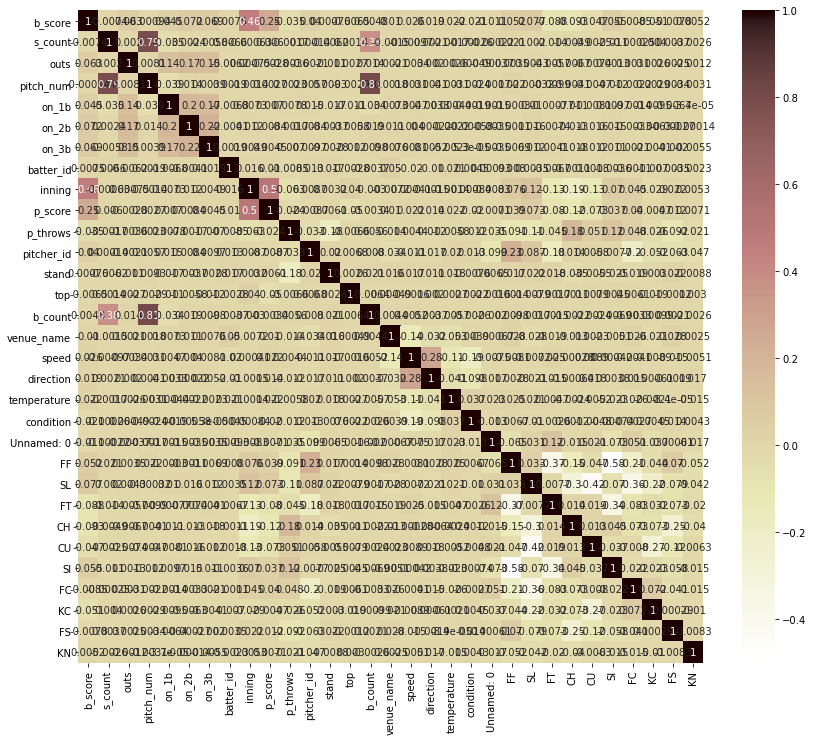

In [65]:
correlation = features.corr() 
plt.figure(figsize=(14,12)) 
heatmap = sns.heatmap(correlation, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

In [66]:
# Drop pitch_num by looking at the correlation plots 
# pitch_num has strong correlation with b_count, s_count
features = features.drop('pitch_num', axis=1)

In [67]:
# y value = pitch_type
target = df['pitch_type']

In [68]:
example = features

In [69]:
target_e = target

In [48]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score
import xgboost as xgb
import random
from sklearn.model_selection import GridSearchCV

## XGBoost

In [74]:
#splitting the train and test data for the XGB model
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance out of the box
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

[[  780    99  5276   193     7    88   850   229]
 [  114   596  4366   231    10     4   521   223]
 [  413   344 29459   467   253   234   417  1988]
 [  132    90  1827  1287    17   106   352    69]
 [    3    11   580    12   360     2    24    46]
 [   35     2   882    50    13   532   134    21]
 [  189   121   320   135    19    76  4572   329]
 [   94    53  7832   121    45    21   980  3135]]
              precision    recall  f1-score   support

          CH       0.44      0.10      0.17      7522
          CU       0.45      0.10      0.16      6065
          FB       0.58      0.88      0.70     33575
          FC       0.52      0.33      0.40      3880
          FS       0.50      0.35      0.41      1038
          KN       0.50      0.32      0.39      1669
          SI       0.58      0.79      0.67      5761
          SL       0.52      0.26      0.34     12281

    accuracy                           0.57     71791
   macro avg       0.51      0.39      0.41     7

In [83]:
# Doesn't work with n_jobs=-1. 
# 만약 계속 안되면 n_jobs=1로 해보셈
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#clf.fit(X_train, y_train)
Xgb_train, Xgb_test, yxgb_train, yxgb_test = train_test_split(example, target_e, test_size=0.20, random_state = 77777)
xgb_param_grid = {"learning_rate": [0.1,1],'max_depth': [2,6],'min_child_weight': [5,10],'n_estimators': [50, 100]}
gs = GridSearchCV(clf, xgb_param_grid, n_jobs=1, cv=3)
gs.fit(Xgb_train, yxgb_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [84]:
gs.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 100}

In [66]:
# put the parameter inside XGBClassifier that u got from gs.best_param
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance with parameters
clf = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,n_estimators=100)
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

[23:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[  644    98  5429   177     9    73   884   208]
 [   92   458  4498   217    12     4   566   218]
 [  294   272 29807   450   219   151   436  1946]
 [  125    87  1932  1193    19    94   368    62]
 [    5     9   603    10   344     0    23    44]
 [   42     0   940    52    14   459   132    30]
 [  189   109   311   134    16    65  4603   334]
 [   72    33  8034   125    41    16   992  2968]]
              precision    recall  f1-score   support

          CH       0.44      0.09      0.14      7522
          CU       0.43      0.08      0.13      6065
          FB       0.58      0.89      0.70     33575
          FC       0.51      0.31      0.38      3880
         

In [87]:
# XGBoost with multi:softprob option

In [ ]:
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)
print(le.classes_)
# list(le.inverse_transform(target_num)) #If you wish to retrieve the original descriptive labels post production

X_train, X_test, y_train, y_test = train_test_split(example, target_num, \
                                                    test_size=0.2, random_state=77777)

# use DMatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
fit = xgb.XGBClassifier(eval_metric='mlogloss', objective = 'multi:softprob')
fit.fit(X_train,y_train)
# set xgboost params
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'learning_rate': 0.1,  # the training step for each iteration
    'min_child_weight': 20,
   'n_estimators': 300,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 10}  # the number of classes that exist in this datset
num_rounds=30
#------------- numpy array ------------------
#training and testing - numpy matrices
bst = xgb.train(param, dtrain,num_rounds)
preds = bst.predict(dtest)

#extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array test precision:", precision_score(y_test, best_preds, average='macro'))

[6 6 6 ... 1 1 1]


In [89]:
xgb_param_grid = {'max_depth': [10,13],'min_child_weight': [15,20] \
                  ,'n_estimators': [250,300], 'num_rounds': [30,60,90]}
gs = GridSearchCV(fit, xgb_param_grid, n_jobs=-1, cv=3)
gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='merror',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=6,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,


In [90]:
gs.best_params_

{'max_depth': 10,
 'min_child_weight': 20,
 'n_estimators': 250,
 'num_rounds': 30}

In [91]:
preds.shape

(215373, 10)

In [92]:
print(preds[:7])

[[0.03890686 0.09104549 0.7325737  0.01410727 0.0141001  0.01409607
  0.01410017 0.05288158 0.01409438 0.01409438]
 [0.11713957 0.01521331 0.6740598  0.07438342 0.01518818 0.01518384
  0.01518826 0.04327959 0.01518202 0.01518202]
 [0.01093814 0.03013653 0.8054743  0.08801582 0.01090491 0.01090179
  0.01090496 0.01092264 0.01090048 0.01090048]
 [0.25073    0.01745642 0.54160345 0.01601203 0.01600389 0.01599932
  0.01600398 0.09419613 0.0159974  0.0159974 ]
 [0.01752513 0.11398576 0.3890661  0.01748076 0.01747188 0.01746689
  0.01747197 0.37460187 0.01746479 0.01746479]
 [0.01496699 0.0149462  0.69557357 0.09782613 0.01492151 0.01491725
  0.01492159 0.10209584 0.01491546 0.01491546]
 [0.17110209 0.03254268 0.6852347  0.01256691 0.01256053 0.01255694
  0.0125606  0.03576465 0.01255544 0.01255544]]


In [93]:
#creating a dataframe for plotting purposes
plot = pd.DataFrame(data=preds[:,:], columns=['Changeup', 'Curveball', 'Cutter', 'Fastball_4S', \
                          'Splitter', 'Fastball_2S', 'Knucklecurve', 'Knuckleball', 'Sinker', \
                                              'Slider'])

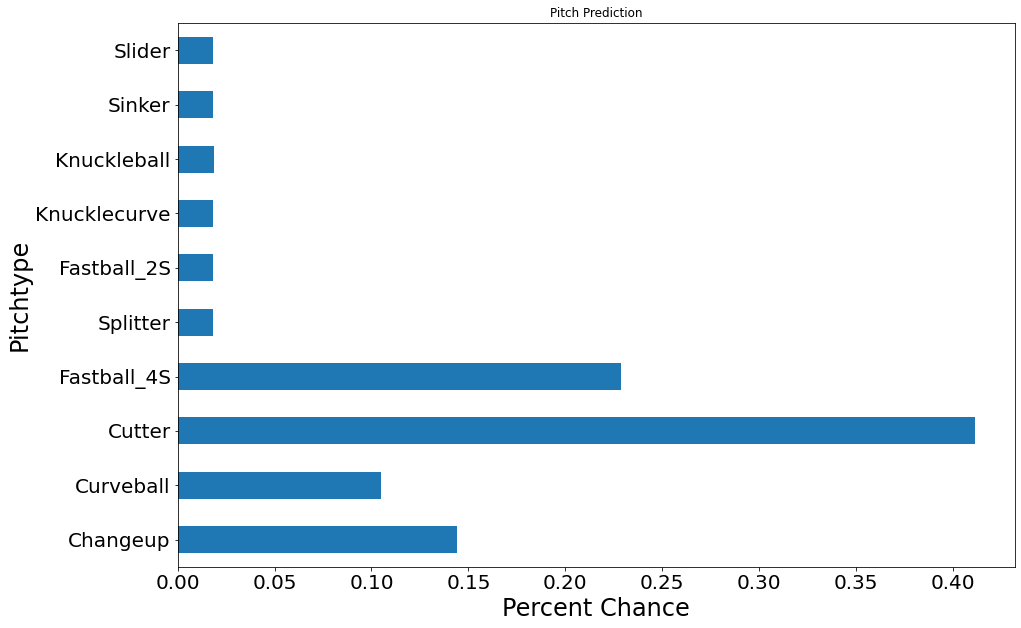

In [94]:
ax = plot.iloc[23].plot(kind='barh',title ="Pitch Prediction", figsize=(15, 10), fontsize=20)
ax.set_xlabel("Percent Chance", fontsize=24)
ax.set_ylabel("Pitchtype", fontsize=24)
plt.show()

## KNN

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_error = []
# Calculating error for K values of 1,4,9,16,25,36,49,64,81,100
for i in range(1, 50):
    #print(i**2)
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    test_error.append(np.mean(pred_i != y_test))
a = min(test_error)
for i in range(0,len(test_error)):
    if test_error[i]==a:
        print(i)

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), test_error, color='grey', linestyle='dashed', marker='o', 
         markerfacecolor='black', markersize=7, label='Testing Set Error Rate')
plt.legend(fontsize = 15)
plt.title('Error Rate K Value', fontsize = 20)
plt.xlabel('K Value', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)

In [ ]:
print(a)

In [ ]:
# Put the number that you got from KNN to n_neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,zero_division=True))

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
#creating a dataframe for plotting purposes
plot = pd.DataFrame(data=val_preds[:,:], columns=['Changeup', 'Curveball', 'Cutter', 'Fastball_4S', 'Splitter', 'Fastball_2S', 'Knucklecurve', 'Knuckleball', 'Sinker', 'Slider'])

#visualization function
def pitch_pred(data):
    print(X_test.iloc[data])
    ax = plot.iloc[data].plot(kind='barh',title ="Pitch Prediction",     figsize=(15, 10), fontsize=20)
    ax.set_xlabel("Percent Chance", fontsize=24)
    ax.set_ylabel("Pitchtype", fontsize=24)
    plt.show()
pitch_pred(3333)

In [ ]:
val_preds

## Support Vector Machine

In [85]:
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.20, random_state = 77777)

In [72]:
!pip install daal4py

In [86]:
from daal4py.sklearn import patch_sklearn
patch_sklearn()

dispatcher.py:151: FutureWarning: 
Scikit-learn patching with daal4py is deprecated and will be removed in the future.
Use Intel(R) Extension for Scikit-learn* module instead (pip install scikit-learn-intelex).
To enable patching, please use one of the following options:
1) From the command line:
    python -m sklearnex <your_script>
2) From your script:
    from sklearnex import patch_sklearn
    patch_sklearn()
Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

## Random Forest

In [ ]:
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)  

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(example, target_num, test_size = 0.10, random_state = 77777)

In [ ]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 2000, max_depth = 10,
 min_samples_leaf = 12,
 min_samples_split = 16)
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
   
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))